In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
import time

# Remove warnings
import warnings
warnings.filterwarnings('ignore') 

In [2]:
df_stores = pd.read_csv(r'C:\Users\Gordo\Desktop\walmart-recruiting-store-sales-forecasting\stores.csv', sep=',')
df_features = pd.read_csv(r'C:\Users\Gordo\Desktop\walmart-recruiting-store-sales-forecasting\features.csv\features.csv', sep=',')
df_train_raw = pd.read_csv(r'C:\Users\Gordo\Desktop\walmart-recruiting-store-sales-forecasting\train.csv\train.csv', sep=',')
df_test_raw = pd.read_csv(r'C:\Users\Gordo\Desktop\walmart-recruiting-store-sales-forecasting\test.csv\test.csv', sep=',')

EDA

In [3]:
def data_prepare(df):
    #table connect
    feature_store = df_features.merge(df_stores, how='inner', on = "Store")
    df = df.merge(feature_store, on=['Store', 'Date', 'IsHoliday'], how = 'inner')

    #data cleaning
    df[['Store', 'Dept']] = df[['Store', 'Dept']].astype(int)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year.astype(int)
    df["Quarter"] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month.astype(int)
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['IsHoliday'] = df['IsHoliday'].astype(int)
    df['Type'] = df['Type'].apply(lambda x: 1 if x == 'A' else (2 if x == 'B' else 3))    
    return df
df_train = data_prepare(df_train_raw)
df_test = data_prepare(df_test_raw)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int32         
 1   Dept          421570 non-null  int32         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  int32         
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  int64         
 15  Size          421

In [5]:
df_train.describe().T

,count,mean,min,25%,50%,75%,max,std
Store,421570.0,22.200546,1.0,11.0,22.0,33.0,45.0,12.785297
Dept,421570.0,44.260317,1.0,18.0,37.0,74.0,99.0,30.492054
Date,421570,2011-06-18 08:30:31.963375104,2010-02-05 00:00:00,2010-10-08 00:00:00,2011-06-17 00:00:00,2012-02-24 00:00:00,2012-10-26 00:00:00,NaN
Weekly_Sales,421570.0,15981.258123,-4988.94,2079.65,7612.03,20205.8525,693099.36,22711.183519
IsHoliday,421570.0,0.070358,0.0,0.0,0.0,0.0,1.0,0.25575
Temperature,421570.0,60.090059,-2.06,46.68,62.09,74.28,100.14,18.447931
Fuel_Price,421570.0,3.361027,2.472,2.933,3.452,3.738,4.468,0.458515
MarkDown1,150681.0,7246.420196,0.27,2240.27,5347.45,9210.9,88646.76,8291.221345
MarkDown2,111248.0,3334.628621,-265.76,41.6,192.0,1926.94,104519.54,9475.357325
MarkDown3,137091.0,1439.421384,-29.1,5.08,24.6,103.99,141630.61,9623.07829


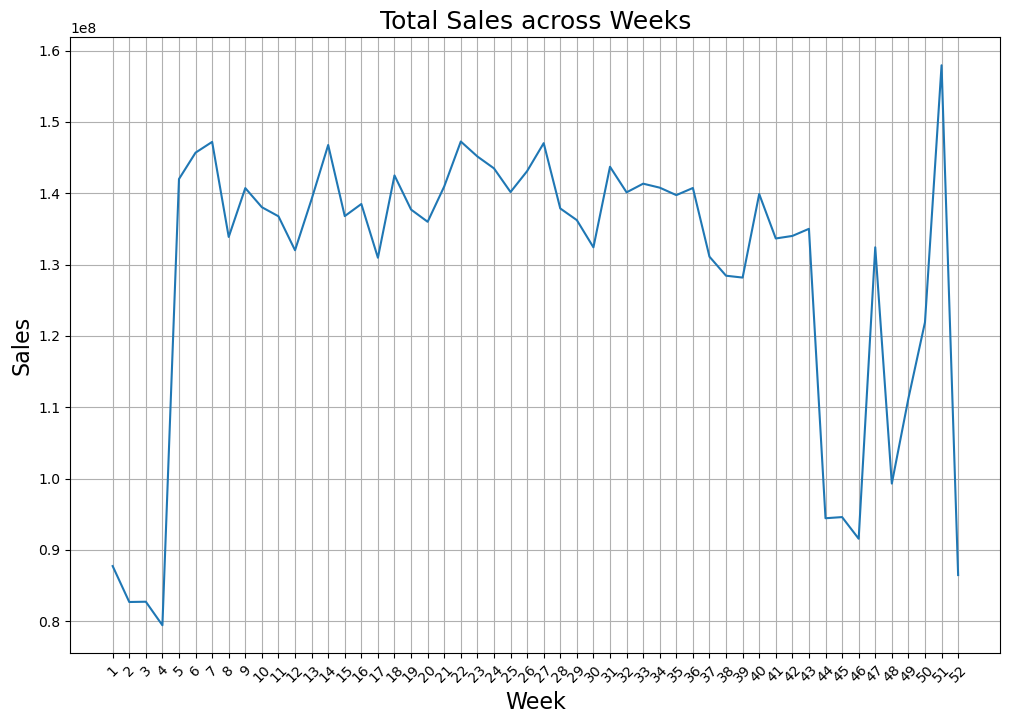

In [6]:
weekly_sales_total = df_train.drop('Date', axis = 1).groupby(df_train['Week']).sum()
plt.figure(figsize = (12,8))
sns.lineplot(x = weekly_sales_total.index, y = weekly_sales_total['Weekly_Sales'])
plt.grid()
plt.xticks(np.arange(1, 53), rotation = 45)
plt.title('Total Sales across Weeks', fontsize = 18)
plt.xlabel('Week', fontsize = 16)
plt.ylabel('Sales', fontsize = 16)
plt.show()

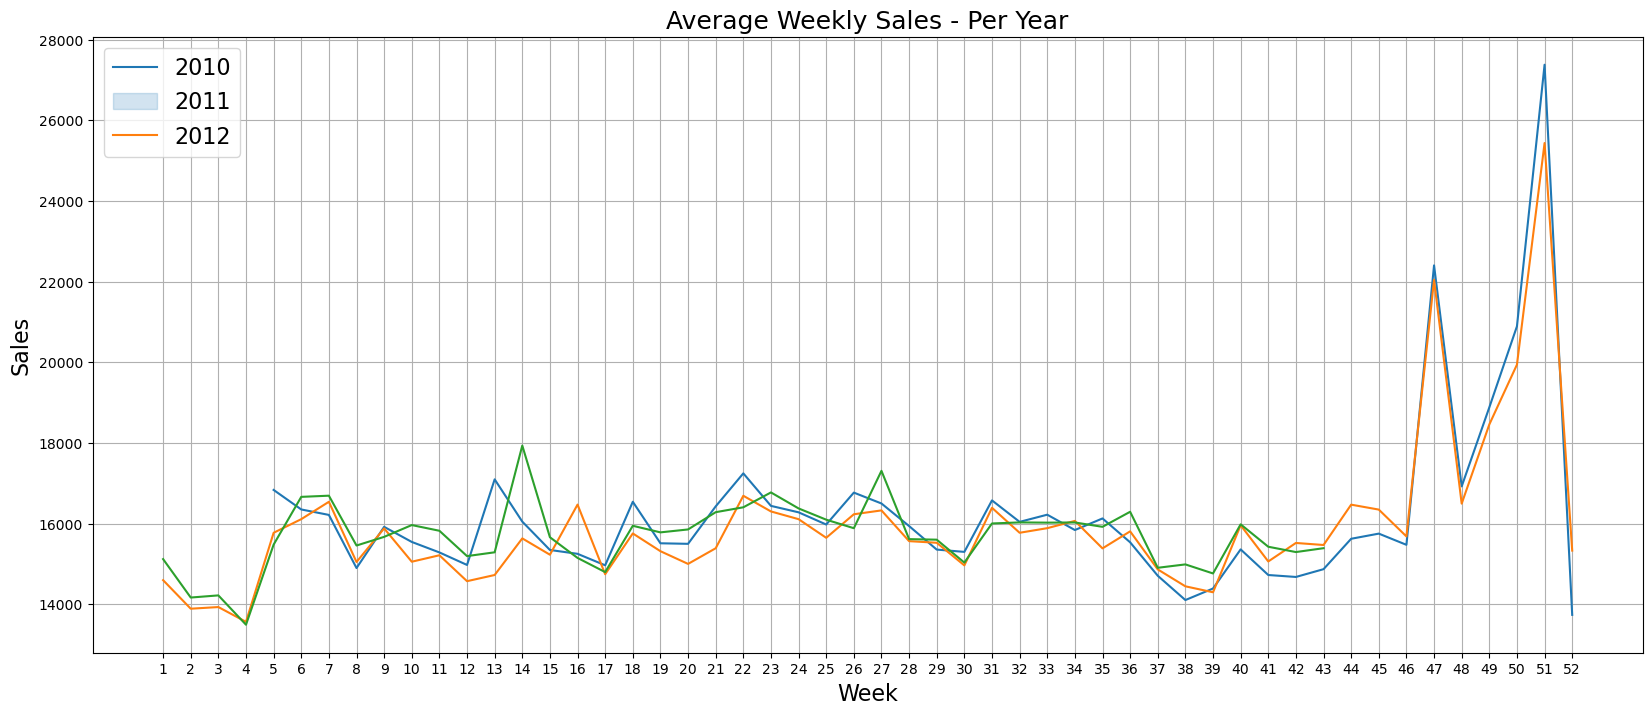

In [7]:
weekly_sales_2010 = df_train[df_train.Year==2010]['Weekly_Sales'].groupby(df_train['Week']).mean()
weekly_sales_2011 = df_train[df_train.Year==2011]['Weekly_Sales'].groupby(df_train['Week']).mean()
weekly_sales_2012 = df_train[df_train.Year==2012]['Weekly_Sales'].groupby(df_train['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(x = weekly_sales_2010.index, y = weekly_sales_2010.values)
sns.lineplot(x = weekly_sales_2011.index, y = weekly_sales_2011.values)
sns.lineplot(x = weekly_sales_2012.index, y = weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

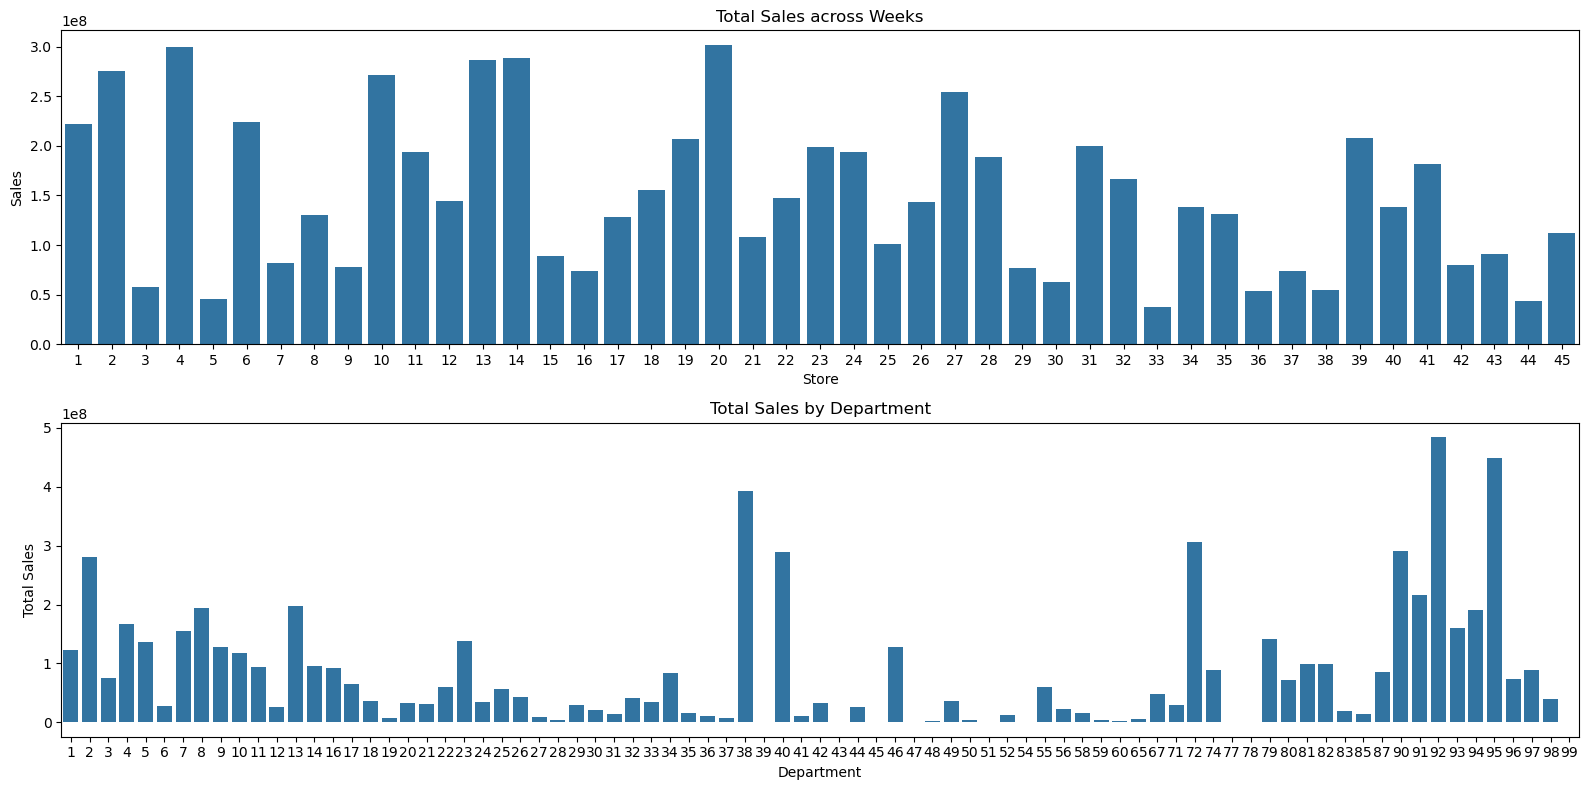

In [8]:
store_sales = df_train.groupby('Store')['Weekly_Sales'].sum().reset_index()
dept_sales = df_train.groupby('Dept')['Weekly_Sales'].sum().reset_index()
fig, axes = plt.subplots(2, 1, figsize=(16, 8))
sns.barplot(x='Store', y='Weekly_Sales', data=store_sales, ax = axes[0])
axes[0].set_title('Total Sales across Weeks')
axes[0].set_xlabel('Store')
axes[0].set_ylabel('Sales')

sns.barplot(x='Dept', y='Weekly_Sales', data=dept_sales, ax=axes[1])
axes[1].set_title('Total Sales by Department')
axes[1].set_xlabel('Department')
axes[1].set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

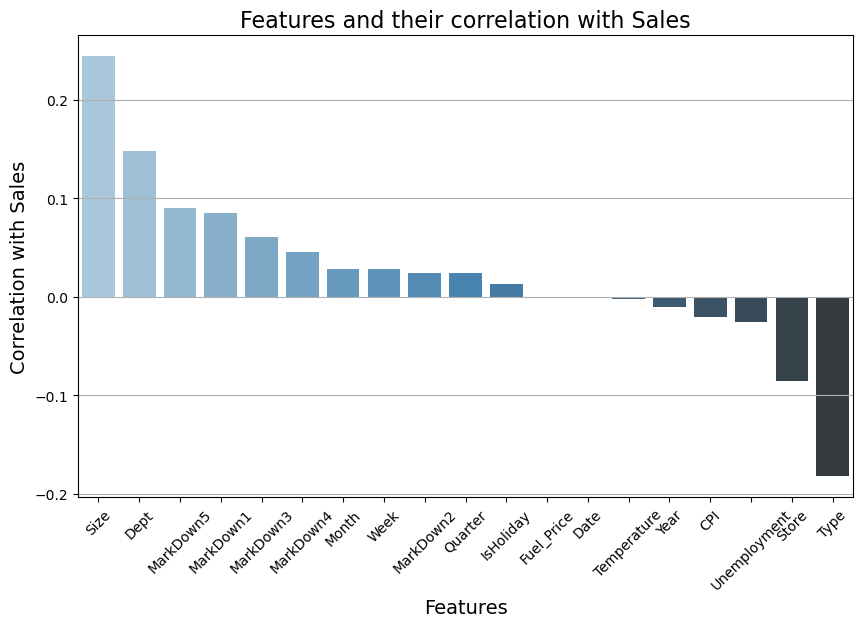

In [9]:
weekly_sales_corr = df_train.corr().loc['Weekly_Sales']
corr_df = pd.DataFrame(data=weekly_sales_corr, index=weekly_sales_corr.index, columns=['Weekly_Sales']).sort_values(by='Weekly_Sales', ascending=False)
corr_df = corr_df.iloc[1:]


plt.figure(figsize=(10, 6))
fig = sns.barplot(x=corr_df.index, y='Weekly_Sales', data=corr_df, palette='Blues_d')


plt.title('Features and their correlation with Sales', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Correlation with Sales', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



In [10]:
#missing value handling
def missing_values_processing(df):
    df['CPI'].fillna(df['CPI'].mean(), inplace = True)
    df['Unemployment'].fillna(df['Unemployment'].mean(), inplace = True)
    df.fillna(0, inplace = True)
    return df
df_train = missing_values_processing(df_train)
df_test = missing_values_processing(df_test)

Feature Engineering

In [11]:
data_train = df_train.copy()
data_test = df_test.copy()

In [12]:
data_train['Year'].unique()

array([2010, 2011, 2012])

In [13]:
def holiday_processing(df):
    df['Days to Thanksgiving'] = (pd.to_datetime(df['Year'].astype(str)+ '-11-24', format = '%Y-%m-%d') - df['Date']).dt.days.astype(int)
    df['Days to Christmas'] = (pd.to_datetime(df['Year'].astype(str)+ '-12-25', format = '%Y-%m-%d') - df['Date']).dt.days.astype(int)
    df['Days to LaborDay'] = (pd.to_datetime(df['Year'].astype(str)+ '-05-01', format = '%Y-%m-%d') - df['Date']).dt.days.astype(int)
    df['Days to SuperBowlWeek'] = np.where(
    df['Year'] == 2010,
    (pd.to_datetime('2010-02-12') - df['Date']).dt.days,
    np.where(
        df['Year'] == 2011,
        (pd.to_datetime('2011-02-11') - df['Date']).dt.days,
        (pd.to_datetime('2012-02-10') - df['Date']).dt.days
    )
)
    df['SuperBowlWeek'] = df['Week'].apply(lambda x: 1 if x == 6 else 0)
    df['LaborDay'] = df['Week'].apply(lambda x: 1 if x == 36 else 0)
    df['Thanksgiving'] = df['Week'].apply(lambda x: 1 if x == 47 else 0)
    df['Christmas'] = df['Week'].apply(lambda x: 1 if x == 52 else 0)
    return df
data_train = holiday_processing(data_train)
data_test = holiday_processing(data_test)

In [14]:
data_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Month,Week,Days to Thanksgiving,Days to Christmas,Days to LaborDay,Days to SuperBowlWeek,SuperBowlWeek,LaborDay,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,2,5,292,323,85,7,0,0,0,0
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,...,2,6,285,316,78,0,1,0,0,0
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,...,2,7,278,309,71,-7,0,0,0,0
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,...,2,8,271,302,64,-14,0,0,0,0
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,...,3,9,264,295,57,-21,0,0,0,0


Modelling

In [15]:
X = data_train.drop(['Date', 'Weekly_Sales'], axis = 1)
y = data_train['Weekly_Sales']

In [16]:
#WMAE
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 4)

In [17]:
#Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(f"Shape of X_train: {X_train.shape}\nShape of y_train: {y_train.shape}\nShape of X_test: {X_test.shape}\nShape of y_test: {y_test.shape}")

Shape of X_train: (337256, 26)
Shape of y_train: (337256,)
Shape of X_test: (84314, 26)
Shape of y_test: (84314,)


In [37]:
# Try to use all default values to run the model
rftree1 = RandomForestRegressor(random_state=42, oob_score=True)

#time calculate
start_time = time.time()
rftree1.fit(X_train, y_train)
end_time = time.time()    

# calculate the training time
training_time = end_time - start_time

#predict
y_pred = rftree1.predict(X_test)

# evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
WMAE_value = WMAE(X_test, y_test, y_pred)
print("R-squared: ", r2)
print("Root of Mean Squared Error: ", rmse)
print("WMAE: ", WMAE_value)

#check result
print("OOB Score: ", round(rftree1.oob_score_,3))
print("Score on Trainset:", round(rftree1.score(X_train, y_train),3))
print("Score on Testset:", round(rftree1.score(X_test, y_test),3)) #predict on test
print("Training time:", training_time)

R-squared:  0.974616666327823
Root of Mean Squared Error:  3638.223771647042
WMAE:  1615.6173
OOB Score:  0.975
Score on Trainset: 0.997
Score on Testset: 0.975
Training time: 425.8768320083618


In [19]:
#Features important table of random forest
fimpt = pd.DataFrame({"Features": X_train.columns, "Importance":rftree.feature_importances_})
fimpt.sort_values("Importance", ascending=False, inplace=True)
print(fimpt)
print(sum(fimpt['Importance']))# adds up to 1.0

                 Features  Importance
1                    Dept    0.625071
13                   Size    0.193173
0                   Store    0.056783
10                    CPI    0.025782
24           Thanksgiving    0.017631
12                   Type    0.014652
11           Unemployment    0.010805
3             Temperature    0.009938
17                   Week    0.009820
18   Days to Thanksgiving    0.006369
20       Days to LaborDay    0.006273
19      Days to Christmas    0.006186
4              Fuel_Price    0.004353
21  Days to SuperBowlWeek    0.003325
7               MarkDown3    0.002543
8               MarkDown4    0.001476
9               MarkDown5    0.001146
5               MarkDown1    0.001019
6               MarkDown2    0.000955
16                  Month    0.000764
25              Christmas    0.000727
2               IsHoliday    0.000568
14                   Year    0.000217
22          SuperBowlWeek    0.000159
23               LaborDay    0.000156
15          

XGBoost

In [20]:
#Try default set
xgbc = XGBRegressor(random_state = 42)
start_time = time.time()
xgbc.fit(X_train, y_train)
end_time = time.time()
y_pred = xgbc.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
WMAE_value = WMAE(X_test, y_test, y_pred)
training_time = end_time - start_time

print("R-squared: ", r2)
print("Root of Mean Squared Error: ", rmse)
print("WMAE: ", WMAE_value)
print("Score on Trainset:", round(xgbc.score(X_train, y_train),3))
print("Score on Testset :", round(xgbc.score(X_test, y_test),3))
print("Training time:", training_time)

R-squared:  0.9469869106930426
Root of Mean Squared Error:  5257.831141869844
WMAE:  3118.9285
Score on Trainset: 0.952
Score on Testset : 0.947
Training time: 0.6755504608154297


In [21]:
#Features important table of xgboost
fimpt = pd.DataFrame({"Features": X_train.columns, "Importance":xgbc.feature_importances_})
fimpt.sort_values("Importance", ascending=False, inplace=True)
print(fimpt)
print(sum(fimpt['Importance']))# adds up to 1.0

                 Features  Importance
24           Thanksgiving    0.354076
1                    Dept    0.177620
13                   Size    0.141501
12                   Type    0.065930
0                   Store    0.063461
15                Quarter    0.037788
17                   Week    0.031275
10                    CPI    0.028261
16                  Month    0.018913
2               IsHoliday    0.018399
18   Days to Thanksgiving    0.014176
11           Unemployment    0.010985
14                   Year    0.008518
3             Temperature    0.006510
7               MarkDown3    0.005574
9               MarkDown5    0.003390
8               MarkDown4    0.003313
23               LaborDay    0.002523
4              Fuel_Price    0.002458
5               MarkDown1    0.002231
6               MarkDown2    0.002060
22          SuperBowlWeek    0.001038
20       Days to LaborDay    0.000000
21  Days to SuperBowlWeek    0.000000
19      Days to Christmas    0.000000
25          

In [22]:
#Try to find the best combination of parameters of xgboost
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the range of parameters
param_distributions = {
    'n_estimators': randint(50, 500),          
    'max_depth': randint(3, 10),               
    'learning_rate': uniform(0.001, 0.3),       
    'subsample': uniform(0.5, 0.9),            
    'colsample_bytree': uniform(0.5, 0.9),     
    'gamma': uniform(0, 0.5),                  
    'reg_alpha': uniform(0, 1),                
    'reg_lambda': uniform(0.1, 2)              
}

#Set RMSE as the evaluation target of random search
scorer = make_scorer(mean_squared_error, squared=False)

# Set random search
random_search = RandomizedSearchCV(estimator=xgb_reg, 
                                   param_distributions=param_distributions, 
                                   n_iter=100,       # 搜索100次随机组合
                                   scoring= scorer,  # 使用RMSE作为评分指标
                                   cv=5,            
                                   verbose=2, 
                                   random_state=42,
                                   n_jobs=-1)        


random_search.fit(X_train, y_train)

#Best model
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

#predict
y_pred = best_model.predict(X_test)

#evaluation
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
WMAE_value = WMAE(X_test, y_test, y_pred)

print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print("WMAE: ", WMAE_value)
print("Score on Trainset:", round(best_model.score(X_train, y_train),3))
print("Score on Testset :", round(best_model.score(X_test, y_test),3))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'colsample_bytree': 0.7507313051287627, 'gamma': 0.08850524213837341, 'learning_rate': 0.027610760127116683, 'max_depth': 3, 'n_estimators': 182, 'reg_alpha': 0.46077876803272577, 'reg_lambda': 0.512667436811585, 'subsample': 0.8278428749432679}
R-squared: 0.6373132126907877
RMSE: 13752.477561580665
WMAE:  8780.2227
Score on Trainset: 0.637
Score on Testset : 0.637


In [23]:
#Check the training time of the best model
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
print(end_time - start_time)

1.6101417541503906


In [24]:
#Features important table of best xgboost model
fimpt = pd.DataFrame({"Features": X_train.columns, "Importance":best_model.feature_importances_})
fimpt.sort_values("Importance", ascending=False, inplace=True)
print(fimpt)
print(sum(fimpt['Importance']))# adds up to 1.0

                 Features  Importance
1                    Dept    0.254728
24           Thanksgiving    0.231542
13                   Size    0.191633
12                   Type    0.143826
0                   Store    0.040061
10                    CPI    0.029388
17                   Week    0.017309
9               MarkDown5    0.017285
11           Unemployment    0.017059
2               IsHoliday    0.015025
18   Days to Thanksgiving    0.014053
19      Days to Christmas    0.008629
7               MarkDown3    0.005579
3             Temperature    0.005257
8               MarkDown4    0.004840
5               MarkDown1    0.003785
20       Days to LaborDay    0.000000
23               LaborDay    0.000000
22          SuperBowlWeek    0.000000
21  Days to SuperBowlWeek    0.000000
15                Quarter    0.000000
16                  Month    0.000000
6               MarkDown2    0.000000
14                   Year    0.000000
4              Fuel_Price    0.000000
25          

In [25]:
#Try to optimize the parameters set of random forest

In [26]:
# Define parameters set
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(8, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

#RandomizedSearchCV
rftree = RandomForestRegressor(random_state=42, oob_score=True)


rmse_scorer = make_scorer(mean_squared_error, squared=False)


random_search = RandomizedSearchCV(
    estimator=rftree,
    param_distributions=param_distributions,
    n_iter=10,               
    scoring=rmse_scorer,     
    cv=5,                    
    verbose=2,
    random_state=42,
    n_jobs=-1 
)


random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)
print("Best RMSE score: ", random_search.best_score_)


best_rftree = random_search.best_estimator_
start_time = time.time()
best_rftree.fit(X_train, y_train)
end_time = time.time()
# 预测和评估
y_pred = best_rftree.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
WMAE_value = WMAE(X_test, y_test, y_pred)
training_time = end_time - start_time

print("R-squared: ", r2)
print("Root Mean Squared Error: ", rmse)
print("WMAE: ", WMAE_value)
print("OOB Score: ", round(best_rftree.oob_score_, 3))
print("Score on Trainset:", round(best_rftree.score(X_train, y_train), 3))
print("Score on Testset:", round(best_rftree.score(X_test, y_test), 3))
print("Training time for best random forest model:", training_time)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 443}
Best RMSE score:  16190.034072388695
R-squared:  0.4980436523275459
Root Mean Squared Error:  16178.865071507593
WMAE:  10671.6116
OOB Score:  0.493
Score on Trainset: 0.505
Score on Testset: 0.498
Training time for best random forest model: 135.43607687950134


In [27]:
#The reuslt of randomized search is not better than the default set of random forest, so the final model is random forest

Evaluation on Test dataset

In [28]:
data_test.head(10)

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Month,Week,Days to Thanksgiving,Days to Christmas,Days to LaborDay,Days to SuperBowlWeek,SuperBowlWeek,LaborDay,Thanksgiving,Christmas
0,1,1,2012-11-02,0,55.32,3.386,6766.44,5147.70,50.82,3639.90,...,11,44,22,53,-185,-266,0,0,0,0
1,1,1,2012-11-09,0,61.24,3.314,11421.32,3370.89,40.28,4646.79,...,11,45,15,46,-192,-273,0,0,0,0
2,1,1,2012-11-16,0,52.92,3.252,9696.28,292.10,103.78,1133.15,...,11,46,8,39,-199,-280,0,0,0,0
3,1,1,2012-11-23,1,56.23,3.211,883.59,4.17,74910.32,209.91,...,11,47,1,32,-206,-287,0,0,1,0
4,1,1,2012-11-30,0,52.34,3.207,2460.03,0.00,3838.35,150.57,...,11,48,-6,25,-213,-294,0,0,0,0
5,1,1,2012-12-07,0,64.12,3.198,6343.16,0.00,270.00,2928.90,...,12,49,-13,18,-220,-301,0,0,0,0
6,1,1,2012-12-14,0,48.89,3.168,3504.83,0.00,73.26,1636.80,...,12,50,-20,11,-227,-308,0,0,0,0
7,1,1,2012-12-21,0,56.02,3.098,8231.71,0.00,274.00,358.15,...,12,51,-27,4,-234,-315,0,0,0,0
8,1,1,2012-12-28,1,44.79,3.108,12659.55,37101.13,174.78,74.46,...,12,52,-34,-3,-241,-322,0,0,0,1
9,1,1,2013-01-04,0,41.73,3.161,1214.08,25366.33,15.01,72.36,...,1,1,324,355,117,-329,0,0,0,0


In [29]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Store                  115064 non-null  int32         
 1   Dept                   115064 non-null  int32         
 2   Date                   115064 non-null  datetime64[ns]
 3   IsHoliday              115064 non-null  int32         
 4   Temperature            115064 non-null  float64       
 5   Fuel_Price             115064 non-null  float64       
 6   MarkDown1              115064 non-null  float64       
 7   MarkDown2              115064 non-null  float64       
 8   MarkDown3              115064 non-null  float64       
 9   MarkDown4              115064 non-null  float64       
 10  MarkDown5              115064 non-null  float64       
 11  CPI                    115064 non-null  float64       
 12  Unemployment           115064 non-null  floa

In [38]:
X = data_test.drop('Date', axis = 1)
y = rftree1.predict(X)
y_df = pd.DataFrame(data=y, columns=['Predicted_Weekly_Sales'])
final_df = pd.concat([data_test.Date, y_df], axis = 1)
final_df.head(20)

,Date,Predicted_Weekly_Sales
0,2012-11-02,32931.4133
1,2012-11-09,18850.9552
2,2012-11-16,18037.0057
3,2012-11-23,18626.4929
4,2012-11-30,19872.2005
5,2012-12-07,45408.7577
6,2012-12-14,32374.0417
7,2012-12-21,54247.7467
8,2012-12-28,18426.5504
9,2013-01-04,20425.1273


In [40]:
final_df.to_csv('Walmart sales forecasting.csv',index=False)